# HMM Analysis Notebook

In [2]:
import os
import re
import glob
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Get data
---
### 1.1 Ground Truth

In [3]:
data = []
for player in glob.glob('../LSTM-Neural-Network-for-Time-Series-Prediction/data/*.csv'):
    tmp = pd.read_csv(player)
    data.append(tmp)
data = pd.concat(data)

In [4]:
data.head()

,Unnamed: 0,Game_Id,Team,Player,Player_Id,Date,Goal,First_Assist,Second_Assist,Total_Points
0,412,2013_20014,VAN,RYAN KESLER,8470616,2013-10-03 00:00:00,0.0,0.0,0.0,0.0
1,1024,2013_20030,VAN,RYAN KESLER,8470616,2013-10-05 00:00:00,1.0,0.0,0.0,1.0
2,1174,2013_20034,VAN,RYAN KESLER,8470616,2013-10-06 00:00:00,0.0,0.0,0.0,0.0
3,1520,2013_20043,VAN,RYAN KESLER,8470616,2013-10-08 00:00:00,0.0,0.0,0.0,0.0
4,2016,2013_20056,VAN,RYAN KESLER,8470616,2013-10-10 00:00:00,0.0,0.0,0.0,0.0


In [5]:
years = ['20132014', '20142015', '20152016', '20162017', '20172018', '20182019']
start_date = [pd.datetime(2013, 10, 1), 
              pd.datetime(2014, 10, 1), 
              pd.datetime(2015, 10, 1), 
              pd.datetime(2016, 10, 1),
              pd.datetime(2017, 10, 1),
              pd.datetime(2018, 10, 1)]
end_date = [pd.datetime(2014, 4, 13), 
            pd.datetime(2015, 4, 11), 
            pd.datetime(2016, 4, 10), 
            pd.datetime(2017, 4, 9),
            pd.datetime(2018, 4, 8),
            pd.datetime(2019, 4, 6)]

yearly_data = {}
i = 0
for y in years:
    print(y)
    print('Points...')
    data['Date'] = pd.to_datetime(data['Date'])
    mask = (data['Date'] > start_date[i]) & (data['Date'] <= end_date[i])
    data_tmp = data.loc[mask]
    yearly_data[y] = data_tmp
    
    i+=1

20132014
Points...
20142015
Points...
20152016
Points...
20162017
Points...
20172018
Points...
20182019
Points...


In [6]:
data_1718 = yearly_data['20172018']
data_1718_agg = data_1718.groupby('Player_Id').agg({'Player': np.unique, 'Total_Points': sum})
data_1718_agg['Name'] = data_1718_agg.Player.apply(lambda player: re.sub(r'\W+', '', f'{player}').upper())
data_1718_agg.set_index('Name', inplace=True)
data_1718_agg.head()

,Player,Total_Points
Name,,
JAROMIRJAGR,JAROMIR JAGR,7.0
MATTCULLEN,MATT CULLEN,22.0
ZDENOCHARA,ZDENO CHARA,24.0
JOETHORNTON,JOE THORNTON,36.0
PATRICKMARLEAU,PATRICK MARLEAU,47.0


### 1.2 HMM Predictions

In [14]:
preds = pd.read_pickle('predictions_hmm_3years.pkl')
preds.head()

,nobs,minmax,mean,variance,skewness,kurtosis
RYAN-KESLER-8470616.csv,500,"(32.0821881330429, 68.9780803631845)",49.7196,35.6007,0.158677,0.0592713
ETHAN-BEAR-8478451.csv,0,0,0,0,0,0
LOGAN-SHAW-8476400.csv,500,"(3.0172290461547866, 28.198255564681446)",14.0617,17.9889,0.295864,-0.0539148
NELSON-NOGIER-8478031.csv,0,0,0,0,0,0
MIKE-SMITH-8469608.csv,500,"(-0.2390873463194673, 7.128388805179847)",1.72711,1.56545,0.707773,0.664747


## 2. Analysis
---

In [15]:
comparison = []
games = []
for name, player in preds.iterrows():
    player_id = name.split('-')[-1].split('.')[0]
    tmp = data[(data.Player_Id == int(player_id))&
                 (data.Date >= pd.datetime(2018, 10, 1))&
                 (data.Date <= pd.datetime(2019, 4, 6))]
    tmp_pts = tmp.Total_Points.sum()
    tmp_gms = tmp.shape[0]
    comparison.append(tmp_pts)
    games.append(tmp_gms)
preds['truth'] = comparison
preds['games'] = games
preds['Total_Points'] = 82*preds['truth']/preds['games']
preds = preds[preds['games'] > 10]

In [16]:
results = preds[['Total_Points']].copy()
results['Prediction'] = preds['mean'].astype(float)
results = results[results['Prediction'] > 0]
results = results.dropna()
results['Difference'] = results['Prediction'] - results['Total_Points']
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,Total_Points,Prediction,Difference
count,665.000000,665.000000,665.000000
mean,33.199639,32.258512,-0.941127
std,24.063945,20.238844,11.999172
min,0.000000,0.000081,-41.940031
10%,6.833333,9.979641,-16.640677
25%,15.870968,17.545021,-7.178515
50%,27.880000,28.597752,-0.287697
75%,46.125000,45.163864,5.809518
90%,68.863802,60.038956,13.468037
max,132.000000,101.859315,38.786224


In [17]:
results

,Total_Points,Prediction,Difference
NIKITA-KUCHEROV-8476453.csv,132.000000,90.059969,-41.940031
TIMO-MEIER-8478414.csv,69.384615,30.030770,-39.353845
MIKKO-RANTANEN-8478420.csv,98.621622,60.224921,-38.396701
ELIAS-LINDHOLM-8477496.csv,78.962963,44.380946,-34.582017
TOMAS-HERTL-8476881.csv,78.805195,44.960683,-33.844512
MARK-GIORDANO-8470966.csv,77.794872,44.418157,-33.376715
LEON-DRAISAITL-8477934.csv,106.000000,73.188951,-32.811049
PATRICE-BERGERON-8470638.csv,99.661538,67.080974,-32.580565
THOMAS-CHABOT-8478469.csv,64.428571,32.263133,-32.165439
BRAYDEN-POINT-8478010.csv,95.493671,63.330701,-32.162970


In [18]:
MAE = round(mean_absolute_error(results['Total_Points'], results['Prediction']), 2)
RMSE = round(mean_squared_error(results['Total_Points'], results['Prediction']), 2)
exp_var_score = round(explained_variance_score(results['Total_Points'], results['Prediction']), 2)
R2 = round(r2_score(results['Total_Points'], results['Prediction']), 2)

print('Mean Absolute Error:', MAE, 'points.')
print('Root Mean Squared Error:', RMSE, 'points.')
print('Explained Variance Score:', exp_var_score)
print('R2 Score:', R2)

Mean Absolute Error: 8.88 points.
Root Mean Squared Error: 144.65 points.
Explained Variance Score: 0.75
R2 Score: 0.75


In [19]:
# results = results.reset_index(level=1)
results.sort_values('Difference')

,Total_Points,Prediction,Difference
NIKITA-KUCHEROV-8476453.csv,132.000000,90.059969,-41.940031
TIMO-MEIER-8478414.csv,69.384615,30.030770,-39.353845
MIKKO-RANTANEN-8478420.csv,98.621622,60.224921,-38.396701
ELIAS-LINDHOLM-8477496.csv,78.962963,44.380946,-34.582017
TOMAS-HERTL-8476881.csv,78.805195,44.960683,-33.844512
MARK-GIORDANO-8470966.csv,77.794872,44.418157,-33.376715
LEON-DRAISAITL-8477934.csv,106.000000,73.188951,-32.811049
PATRICE-BERGERON-8470638.csv,99.661538,67.080974,-32.580565
THOMAS-CHABOT-8478469.csv,64.428571,32.263133,-32.165439
BRAYDEN-POINT-8478010.csv,95.493671,63.330701,-32.162970


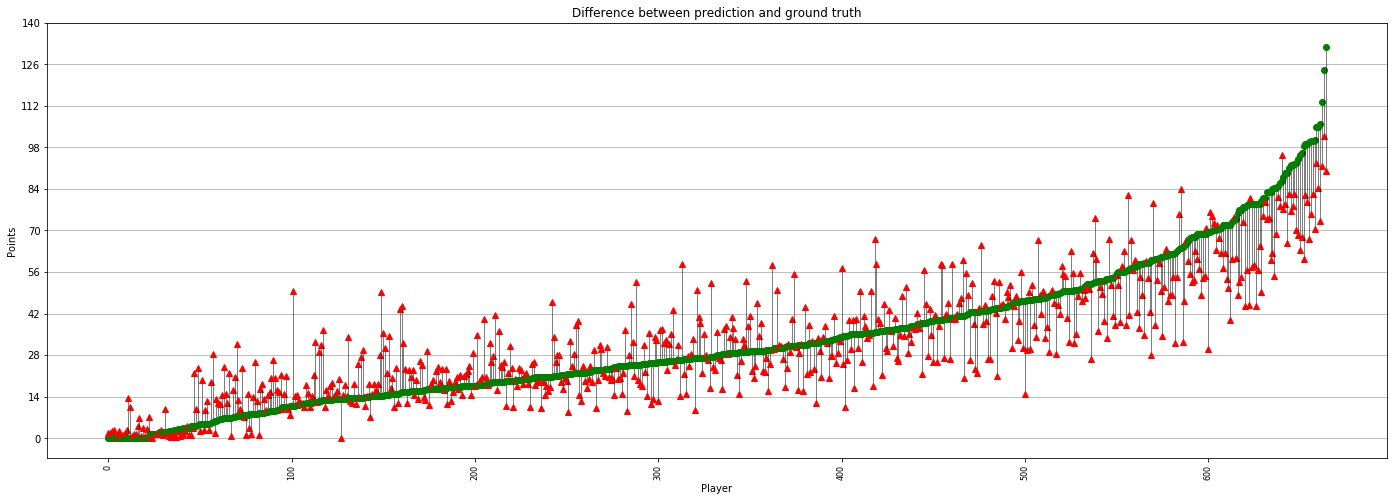

In [20]:
# Sorted indexes
sorted_index = np.argsort(results['Total_Points'])
predictions = results['Prediction']
labels = results['Total_Points']

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(i, labels[sorted_index][i], 'o', label='Ground Truth', color = 'g')
    ax.plot(i, predictions[sorted_index][i], '^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 140, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();